In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

# Change the current working directory to the assignment folder in your google drive
%cd 'gdrive/My Drive/CSE327_Final_Project'

# Import the necessary modules and functions
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import time

from keras.layers import Activation, BatchNormalization, concatenate, Conv2D, Conv2DTranspose, Dropout, Input, Lambda, MaxPool2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from skimage import filters


Mounted at /content/gdrive
/content/gdrive/My Drive/CSE327_Final_Project


In [ ]:
def img_norm(image: np.ndarray, full: bool) -> np.ndarray:
    """
    Normalizes an image between [-1, 1] or [0, 1].

    Parameters:
    image (np.ndarray): The image to be normalized.
    full (bool): If True, the image is normalized between [-1, 1]. If False, it is normalized between [0, 1].

    Returns:
    np.ndarray: The normalized image.
    """
    image_range = np.max(image) - np.min(image)

    if full:
        normalized_image = (2 * (image - np.min(image)) - image_range) / image_range
    else:
        normalized_image = (image - np.min(image)) / image_range

    return normalized_image


In [ ]:
# Image size
img_size = (256, 256)

In [ ]:
from typing import Optional, Tuple

def quadrants(data: np.ndarray, mask: np.ndarray, resize: Optional[Tuple[int, int]]=None) -> Tuple[np.ndarray, np.ndarray]:

  """
  Breaks dataloaders of images and masks into quadrants for faster results.

  Parameters:
  images (np.ndarray): The images to be split into quadrants.
  mask_images (np.ndarray): The mask images to be split into quadrants.
  resize (Optional[Tuple[int, int]]): An optional tuple with the desired size for the quadrants. If specified, the quadrants will be resized to the specified size.

  Returns:
  Tuple[np.ndarray, np.ndarray]: A tuple with the quadrants of the images and mask images.
  """

  if resize:
    assert type(resize) == tuple, f'Tuple expected in quadrants(), received {type(resize)}'

  img_size = resize

  new_data = []
  new_mask = []

  for i in range(len(data)):
    img = data[i,:,:]
    mask_labels = mask[i,:,:]

    top, bottom = np.split(img, 2, axis=0)
    top_mask, bottom_mask = np.split(mask_labels, 2, axis=0)

    top_left, top_right = np.split(top, 2, axis=1)
    bottom_left, bottom_right = np.split(bottom, 2, axis=1)

    top_left_mask, top_right_mask = np.split(top_mask, 2, axis=1)
    bottom_left_mask, bottom_right_mask = np.split(bottom_mask, 2, axis=1)

    if resize:
      new_data.append(cv2.resize(top_left, img_size))
      new_data.append(cv2.resize(top_right, img_size))
      new_data.append(cv2.resize(bottom_left, img_size))
      new_data.append(cv2.resize(bottom_right, img_size))

      new_mask.append(cv2.resize(top_left_mask, img_size))
      new_mask.append(cv2.resize(top_right_mask, img_size))
      new_mask.append(cv2.resize(bottom_left_mask, img_size))
      new_mask.append(cv2.resize(bottom_right_mask, img_size))

    else:
      new_data.append(top_left)
      new_data.append(top_right)
      new_data.append(bottom_left)
      new_data.append(bottom_right)

      new_mask.append(top_left_mask)
      new_mask.append(top_right_mask)
      new_mask.append(bottom_left_mask)
      new_mask.append(bottom_right_mask)

  new_data = np.array(new_data)
  new_mask = np.array(new_mask)

  return new_data, new_mask



In [ ]:
def load_data(augment: bool, num: int) -> Tuple[np.ndarray, np.ndarray]:

  """
  Loads and processes images and masks from the specified directories.

  Parameters:
  augment (bool): A flag indicating whether the data should be augmented with rotated versions of the images and masks.
  num (int): An integer specifying the length of the dataloaders.

  Returns:
  Tuple[np.ndarray, np.ndarray]: A tuple with the processed data and masks.
  """

  img = []
  masks = []

  data_path = './data/MITOCHONDRIA/trainingN/'
  mask_path = './data/MITOCHONDRIA/trainingMaskN/'

  data_path2 = './data/MITOCHONDRIA/testingN/'
  mask_path2 = './data/MITOCHONDRIA/testingMaskN/'

  ids = [img_path[30:-4] for img_path in glob.glob(data_path + '*')]

  ids.sort()

  img2 = []
  masks2 = []

  for id in ids:

    # Image paths
    img_data_path = data_path + id + '.jpg'
    img_data_path2 = data_path2 + id + '.jpg'

    # Add images
    img.append(cv2.resize(cv2.imread(img_data_path, 0), img_size))
    img2.append(cv2.resize(cv2.imread(img_data_path2, 0), img_size))

  for id in ids:

    # Mask paths
    mask_data_path = mask_path + id + '.jpg'
    mask_data_path2 = mask_path2 + id + '.jpg'

    # Read masks in
    mask = cv2.resize(cv2.imread(mask_data_path, 0), img_size)
    mask2 = cv2.resize(cv2.imread(mask_data_path2, 0), img_size)

    # Threshold masks
    mask[mask > 0] = 1
    mask2[mask2 > 0] = 1

    # Convert masks to numpy arrays
    mask = np.array(mask)
    mask2 = np.array(mask2)

    masks.append(mask)
    masks2.append(mask2)

  img.extend(img2)
  masks.extend(masks2)

  print(f'Number of data images: {len(img)}')
  print(f'Number of corresponding masks: {len(masks)}\n')

  # Augmentations
  if augment:

    height, width = img_size

    center = (height // 2, width // 2)

    for i in range(len(img)):

        # Rotate 0, 90, 180, 270 degrees

        degree = random.randrange(0, 3)*90 + 90

        M = cv2.getRotationMatrix2D(center, degree, 1.0)

        rotated_img = cv2.warpAffine(np.array(img[i]), M, img_size)
        rotated_mask = cv2.warpAffine(np.array(masks[i]), M, img_size)

        img.append(rotated_img)
        masks.append(rotated_mask)

    print(f'Number of data images after rotation: {len(img)}')
    print(f'Number of corresponding masks after rotation: {len(masks)}\n')

  img = np.array(img)
  masks = np.array(masks)

  # Split all data into quadrants
  quadrant_img1, quadrant_mask1 = quadrants(img, masks)
  quadrant_img2, quadrant_mask2 = quadrants(quadrant_img1, quadrant_mask1)

  # Shuffle all data and masks together at once
  img_masks = list(zip(quadrant_img2, quadrant_mask2))
  random.shuffle(img_masks)
  img, masks = zip(*img_masks)

  print(f'Number of data images after quartering: {len(img)}')
  print(f'Number of corresponding masks after quartering: {len(masks)}\n')

  # Take last 50 images (they're random as everything was randomly shuffled)
  img = np.array(img[:num])
  masks = np.array(masks[:num])

  # Normalize images
  img_data = img_norm(img, full=False)
  mask_data = img_norm(masks, full=False)

  # Expand dimensions
  img_data = np.expand_dims(img_data, axis=3)
  mask_data = np.expand_dims(mask_data, axis=3)

  print("Dimensions: ", img.shape, masks.shape)
  print("Mask labels : ", np.unique(masks))

  return img_data, mask_data


# Load data in, augment=True
img_data, mask_data = load_data(augment=True, num=2000)

# Load trainloaders and testloaders
Xtrainloader, Xtestloader, ytrainloader, ytestloader = train_test_split(img_data, mask_data, test_size = 0.30, random_state = 42)

Number of data images: 120
Number of corresponding masks: 120

Number of data images after rotation: 240
Number of corresponding masks after rotation: 240

Number of data images after quartering: 3840
Number of corresponding masks after quartering: 3840

Dimensions:  (2000, 64, 64) (2000, 64, 64)
Mask labels :  [0 1]


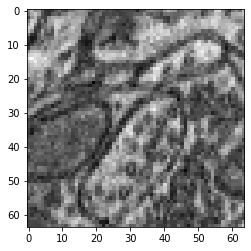

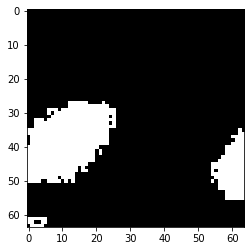


Unique values in mask: [0. 1.]


In [ ]:
# Function for showing an image and a corresponding mask
def img_show(x: np.ndarray, y: np.ndarray, num: int = 0) -> None:
  """
  Shows an image and a corresponding mask.

  Parameters:
  images (np.ndarray): The images to be displayed.
  mask_images (np.ndarray): The mask images to be displayed.
  num (int): The index of the image and mask to be displayed.

  Returns:
  None.
  """

  img = x[num,:,:, 0]
  mask = y[num,:,:, 0]

  plt.imshow(img, cmap='gray')
  plt.show()
  plt.imshow(mask, cmap='gray')
  plt.show()

  print(f'\nUnique values in mask: {np.unique(mask)}')

img_show(Xtrainloader, ytrainloader, random.randrange(0, len(Xtrainloader) + 1))

In [ ]:
import tensorflow as tf

def Encoder(x, n):
  """
  Encoder block of the U-Net model.

  Args:
    x: Input tensor.
    n: Number of filters to use in the convolutional layers.

  Returns:
    A tuple containing the output tensor and the max-pooled tensor.
  """
  x = Conv2D(n, 3, padding='same')(x)
  x = BatchNormalization()(x)
  p = Dropout(0.1)(x)
  x = Activation("relu")(x)
  x = Conv2D(n, 3, padding='same')(x)
  x = BatchNormalization()(x)
  p = Dropout(0.1)(x)
  x = Activation("relu")(x)
  p = MaxPool2D((2, 2)) (x)

  return x, p

def Decoder(x, n, encoder_features):
  """
  Decoder block of the U-Net model.

  Args:
    x: Input tensor.
    n: Number of filters to use in the convolutional layers.
    encoder_features: Output tensor from the corresponding encoder block.

  Returns:
    The output tensor.
  """
  x = Conv2DTranspose(n, (2, 2), strides=2, padding="same")(x)
  x = concatenate([x, encoder_features])
  x = Conv2D(n, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.1)(x)
  x = Activation("relu")(x)
  x = Conv2D(n, 3, padding='same')(x)
  x = BatchNormalization()(x)
  p = Dropout(0.1)(x)
  x = Activation("relu")(x)

  return x

def get_Unet(img_size):
  """
  Builds the U-Net model.

  Args:
    img_size: Size of the input image, in the format (height, width, channels).

  Returns:
    The U-Net model.
  """
  inputs = tf.keras.Input(img_size)

  e1, p1 = Encoder(inputs, 64)
  e2, p2 = Encoder(p1, 128)
  e3, p3 = Encoder(p2, 256)
  e4, p4 = Encoder(p3, 512)

  x = Conv2D(1024, 3, padding='same')(p4)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = Conv2D(1024, 3, padding='same')(p4)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  d1 = Decoder(x, 512, e4)
  d2 = Decoder(d1, 256, e3)
  d3 = Decoder(d2, 128, e2)
  d4 = Decoder(d3, 64, e1)

  outputs = Conv2D(1, 1, padding="same", activation='sigmoid')(d4)
  model = Model(inputs, outputs, name="UNet")

  return model


In [ ]:
def train_model(Xtrainloader, ytrainloader, Xtestloader, ytestloader, epochs, metric_i, input_shape):
    """
    This function trains a model with the given data and parameters.

    Parameters:
    Xtrainloader (numpy array): Array of training data images.
    ytrainloader (numpy array): Array of training data masks.
    Xtestloader (numpy array): Array of test data images.
    ytestloader (numpy array): Array of test data masks.
    epochs (int): Number of epochs to train the model for.
    metric_i (int): Index of the metric to use for evaluation.
    input_shape (tuple): Shape of the input data.

    Returns:
    Keras model: Trained model.
    """
    # Load the model, along with loss, metrics
    model = get_Unet(input_shape)
    loss = 'binary_crossentropy'
    metrics = ['accuracy', tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])]

    # Compile the model
    model.compile(optimizer=Adam(learning_rate = 1e-5),
                                loss=loss,
                                metrics=[metrics[metric_i]])

    # Fit the model
    fitted = model.fit(x=Xtrainloader, y=ytrainloader,
                        batch_size = 10,
                        verbose=1,
                        epochs=epochs,
                        validation_data=(Xtestloader, ytestloader),
                        # sample_weight = weights
                        )

    return model, fitted

# Number of epochs
epochs = 25

metric_i = 0

input_shape = (Xtrainloader.shape[1], Xtrainloader.shape[2], 1)

print(f'Input shape is: {input_shape}')

# Train the model
model, fitted = train_model(Xtrainloader, ytrainloader, Xtestloader, ytestloader, epochs, metric_i, input_shape)

Input shape is: (64, 64, 1)
Epoch 1/25
140/140 [==============================] - 593s 4s/step - loss: 0.5856 - accuracy: 0.7068 - val_loss: 0.6376 - val_accuracy: 0.8306
Epoch 2/25
140/140 [==============================] - 590s 4s/step - loss: 0.3984 - accuracy: 0.9031 - val_loss: 0.3914 - val_accuracy: 0.9077
Epoch 3/25
140/140 [==============================] - 587s 4s/step - loss: 0.2445 - accuracy: 0.9587 - val_loss: 0.3119 - val_accuracy: 0.9078
Epoch 4/25
140/140 [==============================] - 590s 4s/step - loss: 0.1910 - accuracy: 0.9658 - val_loss: 0.2362 - val_accuracy: 0.9371
Epoch 5/25
140/140 [==============================] - 589s 4s/step - loss: 0.1617 - accuracy: 0.9720 - val_loss: 0.1899 - val_accuracy: 0.9651
Epoch 6/25
140/140 [==============================] - 589s 4s/step - loss: 0.1444 - accuracy: 0.9750 - val_loss: 0.1468 - val_accuracy: 0.9704
Epoch 7/25
140/140 [==============================] - 588s 4s/step - loss: 0.1311 - accuracy: 0.9778 - val_loss: 0

In [ ]:
# model.save('./saved_models/m_segmentation_2Q_64x64_25E_2000imgs.hdf5')

In [ ]:
# Epoch range
epoch_range = np.arange(1, epochs + 1)

fitted_train = ['accuracy', 'io_u']
fitted_val = ['val_accuracy', 'val_io_u']

# Load in losses and accuracies
loss =  fitted.history['loss']
val_loss = fitted.history['val_loss']
accuracy = fitted.history[fitted_train[metric_i]]
val_accuracy = fitted.history[fitted_val[metric_i]]

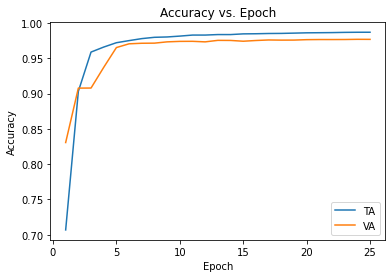

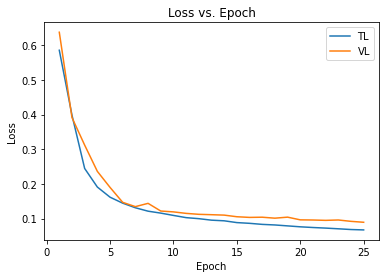

In [ ]:
# Accuracy plot
plt.plot(epoch_range, accuracy, label='TA')
plt.plot(epoch_range, val_accuracy, label='VA')

plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Loss plot
plt.plot(epoch_range, loss, label='TL')
plt.plot(epoch_range, val_loss, label='VL')

plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model = load_model('./saved_models/m_segmentation_2Q_64x64_25E_2000imgs.hdf5')

In [ ]:
# Predict images based on testloader
ypredicted=model.predict(Xtestloader)

19/19 [==============================] - 60s 3s/step


[0.01114066 0.01541365 0.01581125 ... 0.9999999  0.99999994 1.        ]


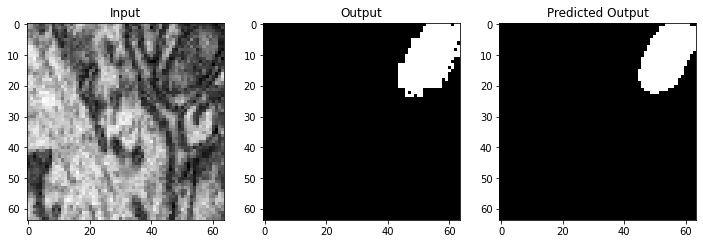

In [ ]:
# Set the index of the image to be plotted
img_i = random.randrange(0, len(Xtestloader))

# Set the threshold for converting the predicted output to binary
threshold = 0.5

# Print the unique values of the predicted output (these are probabilities)
print(np.unique(ypredicted[img_i, :, :, 0]))

# Define titles and data loaders
titles = ['Input', 'Output', 'Predicted Output']
dataloaders = [Xtestloader, ytestloader, ypredicted]

# Create a figure with 1 row and 3 columns
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Iterate through each subplot and plot the corresponding data loader
for i, ax in enumerate(axs.flatten()):
    # If this is the predicted output subplot, use a threshold to convert it to binary
    if i == 2:
        plt.sca(ax)
        plt.imshow(dataloaders[i][img_i, :, :, 0] >= threshold, cmap='gray')
        plt.title('Predicted Output')
    # For the other subplots, simply plot the data
    else:
        plt.sca(ax)
        plt.imshow(dataloaders[i][img_i, :, :, 0], cmap='gray')
        plt.title(f'{titles[i]}')

# Show the figure
plt.show()